In [170]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import os, sys
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from datetime import datetime
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [197]:
def fitNormGP(mydf, cov, yname):
    use_kernel = C() * RBF() + WhiteKernel(noise_level_bounds=(1e-06, 100000.0))
    myGPR = GaussianProcessRegressor(n_restarts_optimizer=5, kernel=use_kernel, normalize_y=True)
    
    X = mydf.loc[:, cov]
    tmp_scale = StandardScaler()
    Xsc = tmp_scale.fit_transform(X)
    
    y = mydf.loc[:, yname]
    
    myGPR.fit(Xsc, y)
    
    res = {}
    res['target'] = yname
    res['cov'] = cov
    res['scaler'] = tmp_scale
    res['GPR'] = myGPR
    return(res)

In [198]:
def feat2z(mydf, gpmodel):
    #assert(gpmodel['target'] == yname)
    yname = gpmodel['target']
    cov = gpmodel['cov']
    X = mydf.loc[:,cov]
    y = mydf.loc[:, yname]
    
    Xinp = gpmodel['scaler'].transform(X)
    
    means, sds = gpmodel['GPR'].predict(Xinp, return_std=True)
    
    myz = (y-means)/sds
    
    return(myz)

In [200]:
tfeat=['Hippocampus']

<AxesSubplot:xlabel='timeline'>

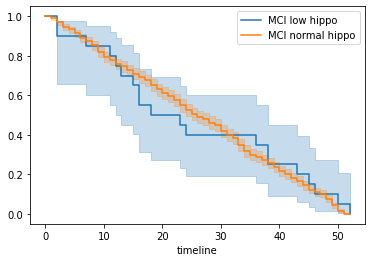

In [266]:
data_ZGPlow_hippo=data_ZGPMCI.loc[data_ZGPMCI['Hippocampus']<-1.63]
data_ZGPhigh_hippo=data_ZGPMCI.loc[data_ZGPMCI['Hippocampus']>=-1.63]

km.fit(data_ZGPlow_hippo['week of the year'], data_ZGPlow_hippo['DX_bl_coded'], label='MCI low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(data_ZGPhigh_hippo['week of the year'], data_ZGPhigh_hippo['DX_bl_coded'], label='MCI normal hippo')
km.plot(ax=a1)

<AxesSubplot:>

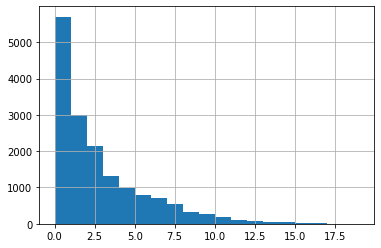

In [227]:
ADNIMERGE=pd.read_csv('ADNIMERGE.csv',low_memory=False)
ADNIMERGE.Years_bl.hist(bins=range(0,20,1))

In [228]:
CN_data=ADNIMERGE[ADNIMERGE['DX_bl'].isin(['CN'])]
CN_data.shape

(4871, 116)

In [229]:
LMCI_data=ADNIMERGE[ADNIMERGE['DX_bl'].isin(['LMCI'])]
LMCI_data.shape

(5245, 116)

In [230]:
AD_data=ADNIMERGE[ADNIMERGE['DX_bl'].isin(['AD'])]
AD_data.shape

(1740, 116)

In [234]:
#Check if any CN transform to LMCI or AD
CN_to_LMCI=LMCI_data[LMCI_data['PTID'].isin(CN_data['PTID'])]
CN_to_LMCI.shape

(0, 116)

In [235]:
CN_to_AD=AD_data[AD_data['PTID'].isin(CN_data['PTID'])]
CN_to_AD.shape

(0, 116)

In [260]:
CN_subjs_list=CN_data.PTID.unique()
LMCI_subjs_list=LMCI_data.PTID.unique()
AD_subjs_list=AD_data.PTID.unique()

In [253]:
def get_max_idx(subjs_list,data):
    max_idx_bl_years=[]
    for subj in subjs_list:
        df=data[data['PTID'].isin([f'{subj}'])]
        subj_idx_max=df.Years_bl.idxmax()
        max_idx_bl_years.append(subj_idx_max)
    return max_idx_bl_years

In [262]:
CN_max_idx_bl_years=get_max_idx(CN_subjs_list,CN_data)
LMCI_max_idx_bl_years=get_max_idx(LMCI_subjs_list,LMCI_data)
AD_max_idx_bl_years=get_max_idx(AD_subjs_list,AD_data)

In [263]:
CN_data['Suvival']=0
LMCI_data['Suvival']=0
AD_data['Suvival']=0

CN_data.loc[CN_max_idx_bl_years,'Suvival']=1
LMCI_data.loc[LMCI_max_idx_bl_years,'Suvival']=1
AD_data.loc[AD_max_idx_bl_years,'Suvival']=1

/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_50995/2227455547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN_data['Suvival']=0
/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_50995/2227455547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMCI_data['Suvival']=0
/var/folders/wy/6tng9d3d0j1dm7v45z4ylz880000gn/T/ipykernel_50995/2227455547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

<AxesSubplot:xlabel='timeline'>

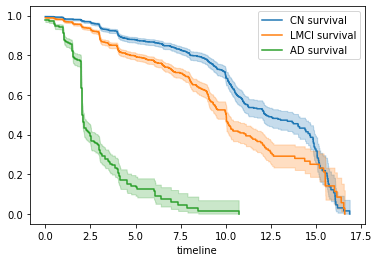

In [264]:

km.fit(CN_data['Years_bl'], CN_data['Suvival'], label='CN survival')
a1 = km.plot()

km.fit(LMCI_data['Years_bl'], LMCI_data['Suvival'], label='LMCI survival')
a2=km.plot(ax=a1)

km.fit(AD_data['Years_bl'], AD_data['Suvival'], label='AD survival')
km.plot(ax=a2)

In [274]:
CN_data_covs=CN_data[['AGE','ICV','Hippocampus']]
CN_data_covs=CN_data_covs.dropna()

LMCI_data_covs=LMCI_data[['Years_bl','Suvival','AGE','ICV','Hippocampus']]
LMCI_data_covs=LMCI_data_covs.dropna()

In [280]:
AD_data_covs=AD_data[['Years_bl','Suvival','AGE','ICV','Hippocampus']]
AD_data_covs=AD_data_covs.dropna()

In [276]:
LMCI_data_ZGP=LMCI_data_covs[['Years_bl','Suvival','AGE','ICV','Hippocampus']]
for fff in tfeat:
    sys.stderr.write("Estimating model for " + fff + "\n" )
    tmp_mod = fitNormGP(CN_data_covs, ['AGE','ICV'], fff)
    tmpz    = feat2z(LMCI_data_covs, tmp_mod)
    LMCI_data_ZGP.loc[:,fff] = tmpz

Estimating model for Hippocampus


In [281]:
AD_data_ZGP=AD_data_covs[['Years_bl','Suvival','AGE','ICV','Hippocampus']]
for fff in tfeat:
    sys.stderr.write("Estimating model for " + fff + "\n" )
    tmp_mod = fitNormGP(CN_data_covs, ['AGE','ICV'], fff)
    tmpz    = feat2z(AD_data_covs, tmp_mod)
    AD_data_ZGP.loc[:,fff] = tmpz

Estimating model for Hippocampus


<AxesSubplot:xlabel='timeline'>

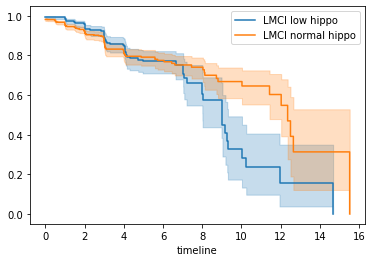

In [279]:
LMCI_data_ZGPlow_hippo=LMCI_data_ZGP.loc[LMCI_data_ZGP['Hippocampus']<-1.63]
LMCI_data_ZGPhigh_hippo=LMCI_data_ZGP.loc[LMCI_data_ZGP['Hippocampus']>=-1.63]

km.fit(LMCI_data_ZGPlow_hippo['Years_bl'], LMCI_data_ZGPlow_hippo['Suvival'], label='LMCI low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(LMCI_data_ZGPhigh_hippo['Years_bl'], LMCI_data_ZGPhigh_hippo['Suvival'], label='LMCI normal hippo')
km.plot(ax=a1)

In [283]:
from lifelines.statistics import logrank_test
results=logrank_test(LMCI_data_ZGPlow_hippo['Years_bl'],LMCI_data_ZGPhigh_hippo['Years_bl'],event_observed_A=LMCI_data_ZGPlow_hippo['Suvival'], event_observed_B=LMCI_data_ZGPhigh_hippo['Suvival'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.23 0.63      0.66

In [284]:
results.p_value

0.6331939762653014

<AxesSubplot:xlabel='timeline'>

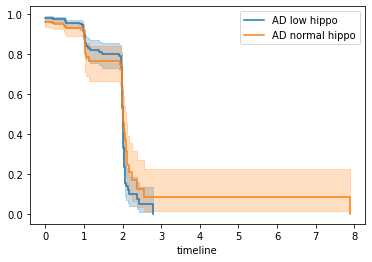

In [282]:
AD_data_ZGPlow_hippo=AD_data_ZGP.loc[AD_data_ZGP['Hippocampus']<-1.63]
AD_data_ZGPhigh_hippo=AD_data_ZGP.loc[AD_data_ZGP['Hippocampus']>=-1.63]

km.fit(AD_data_ZGPlow_hippo['Years_bl'], AD_data_ZGPlow_hippo['Suvival'], label='AD low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(AD_data_ZGPhigh_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Suvival'], label='AD normal hippo')
km.plot(ax=a1)

In [285]:
results=logrank_test(AD_data_ZGPlow_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Years_bl'],event_observed_A=AD_data_ZGPlow_hippo['Suvival'], event_observed_B=AD_data_ZGPhigh_hippo['Suvival'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.29 0.59      0.76

In [359]:
def get_best_cutoff(data_ZGP):
    cutoff=0
    p_val=0.9
    final_cutoff=0
    while cutoff>-3:
        data_ZGPlow_hippo=data_ZGP.loc[data_ZGP['Hippocampus']<cutoff]
        data_ZGPhigh_hippo=data_ZGP.loc[data_ZGP['Hippocampus']>=cutoff]

        results=logrank_test(data_ZGPlow_hippo['Years_bl'],data_ZGPhigh_hippo['Years_bl'],event_observed_A=data_ZGPlow_hippo['Suvival'], event_observed_B=data_ZGPhigh_hippo['Suvival'])
        current_p_val=results.p_value
        if current_p_val<p_val:
            p_val=current_p_val
            final_cutoff=cutoff
        cutoff=cutoff-0.3
    return p_val, final_cutoff

In [361]:
AD_p_val,AD_final_cutoff=get_best_cutoff(AD_data_ZGP)
AD_p_val,AD_final_cutoff

(0.12936694666016246, -1.2)

<AxesSubplot:xlabel='timeline'>

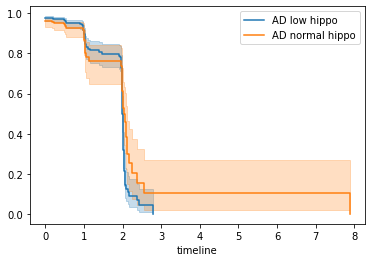

In [356]:
AD_data_ZGPlow_hippo=AD_data_ZGP.loc[AD_data_ZGP['Hippocampus']<AD_final_cutoff]
AD_data_ZGPhigh_hippo=AD_data_ZGP.loc[AD_data_ZGP['Hippocampus']>=AD_final_cutoff]

km.fit(AD_data_ZGPlow_hippo['Years_bl'], AD_data_ZGPlow_hippo['Suvival'], label='AD low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(AD_data_ZGPhigh_hippo['Years_bl'],AD_data_ZGPhigh_hippo['Suvival'], label='AD normal hippo')
km.plot(ax=a1)

In [362]:
LMCI_p_val,LMCI_final_cutoff=get_best_cutoff(LMCI_data_ZGP)
LMCI_p_val,LMCI_final_cutoff

(0.20421670294235525, -2.4)

<AxesSubplot:xlabel='timeline'>

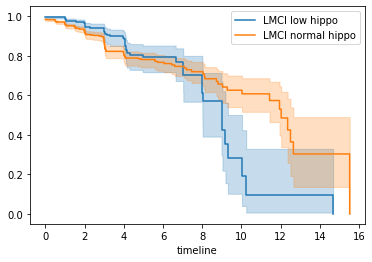

In [358]:
LMCI_data_ZGPlow_hippo=LMCI_data_ZGP.loc[LMCI_data_ZGP['Hippocampus']<LMCI_final_cutoff]
LMCI_data_ZGPhigh_hippo=LMCI_data_ZGP.loc[LMCI_data_ZGP['Hippocampus']>=LMCI_final_cutoff]

km.fit(LMCI_data_ZGPlow_hippo['Years_bl'], LMCI_data_ZGPlow_hippo['Suvival'], label='LMCI low hippo')
a1 = km.plot()

# fit the model for 2nd cohort
km.fit(LMCI_data_ZGPhigh_hippo['Years_bl'], LMCI_data_ZGPhigh_hippo['Suvival'], label='LMCI normal hippo')
km.plot(ax=a1)